In [13]:
#SKU FORECAST AND INVENTORY
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ttest_rel
from datetime import timedelta

In [14]:
# Load data
orders = pd.read_csv("order_data_last_six_month.csv")
order_items = pd.read_csv("associated_order_item_data_last_six_month.csv")

In [15]:
orders

,order_date,order_id,order_number,customer_id,customer_name,poc_name,poc_id,amount,discount,net_order_amount,profit,order_status,warehouse_name,warehouse_id
0,03/04/2025,136349,SO/25-26/000818,5235,Anshu General Store Sector 34,Vikas Gupta,6,19125.00,1650.00,17475.0,0.0,CLOSED,Noida,3
1,30/01/2025,110393,SO/24-25/90881,7622,bhai di rasoi,Abhay Srimali,7814,9670.48,735.48,8935.0,-56.4,CLOSED,Greater NOIDA,6
2,12/02/2025,116427,SO/24-25/96511,3827,Shama chicken corner beta,Yash Pandey,51,62500.00,5000.00,57500.0,-650.0,CLOSED,Noida,3
3,26/12/2024,96182,SO/24-25/77411,2223,Bikaner Sweets ( Harola ),Swatantra,25,4520.00,420.00,4100.0,40.0,CLOSED,Noida,3
4,30/12/2024,97858,SO/24-25/78975,6903,Lucknow kirana store,Raj Kumar,7039,1700.00,0.00,1700.0,-88.0,CLOSED,Gomti Nagar,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64454,26/12/2024,96152,SO/24-25/77382,948,Maa Bindwa,Utkarsh Pratap Singh,17,1650.00,130.00,1520.0,-60.0,CLOSED,Gomti Nagar,1
64455,26/12/2024,96153,SO/24-25/77392,5822,Yaduvanshi General Store,Raza Rizvi,5602,8255.00,935.00,7320.0,-455.0,CLOSED,Telibagh,2
64456,25/12/2024,96166,SO/24-25/77390,1655,Brijwasi sweet and restaurant (115),Ashutosh Tripathi,37,20970.00,2140.00,18830.0,-195.0,CLOSED,Noida,3
64457,26/12/2024,96173,SO/24-25/77401,4268,Ashutosh Traders,Mohd Yaqoob,4293,3508.00,198.00,3310.0,-30.0,CLOSED,Telibagh,2


In [16]:
order_items[order_items['order_id']==136349]
# order_items

,order_id,order_number,order_item_id,item_name,quantity,invoiced_quantity,mrp,price_per_unit,amount,discount_amount,profit
110347,136349,SO/25-26/000818,257223,Ruchi Gold Palm Pouch(1L),15,15,1275.0,1165.0,19125.0,1650.0,0.0


In [17]:
# Parse dates
orders["order_date"] = pd.to_datetime(orders["order_date"], dayfirst=True)

# Merge orders and items
data = pd.merge(order_items, orders[['order_date','customer_id','order_id','warehouse_name','warehouse_id']], on="order_id",how='left')
# data["day_of_week"] = data["order_date"].dt.dayofweek
# data["month"] = data["order_date"].dt.month
data.drop(columns=['order_number','order_item_id'], inplace=True)
data

,order_id,item_name,quantity,invoiced_quantity,mrp,price_per_unit,amount,discount_amount,profit,order_date,customer_id,warehouse_name,warehouse_id
0,104592,Anannya Rice,2,2,1732.000,1534.0,3464.00,396.00,-208.00,2025-01-16,5980,Telibagh,2
1,74112,Ambey Patent Maida,1,1,1899.000,1760.0,1899.00,139.00,-10.00,2024-10-22,5540,Noida,3
2,105873,Arhar Dal,10,0,173.567,127.0,1735.67,465.67,-377.00,2025-01-19,1119,Telibagh,2
3,112302,Kezar Maida,5,5,1760.000,1652.0,8800.00,540.00,-140.00,2025-02-04,3776,Gomti Nagar,1
4,74308,Normal Sugar,1,1,2190.000,2110.0,2190.00,80.00,40.00,2024-10-22,5569,Telibagh,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115088,139435,SAPNA GOLD AATA,2,0,2010.000,1470.0,4020.00,1080.00,-780.00,2025-04-10,7869,Ayodhya,4
115089,139433,Hum Tum Rice,5,0,1390.000,1215.0,6950.00,875.00,-375.00,2025-04-10,7806,Ayodhya,4
115090,139431,Masodha Double Filter Sugar,4,0,2430.000,2210.0,9720.00,880.00,-160.00,2025-04-10,7806,Ayodhya,4
115091,139430,Matar,10,0,54.675,45.0,546.75,96.75,-56.75,2025-04-10,4982,Ayodhya,4


In [18]:
data[(data['customer_id']==1)&(data['item_name']=='Arrarot')]

,order_id,item_name,quantity,invoiced_quantity,mrp,price_per_unit,amount,discount_amount,profit,order_date,customer_id,warehouse_name,warehouse_id
5611,69442,Arrarot,1,1,2340.0,2220.0,2340.0,120.0,20.0,2024-10-06,1,Telibagh,2
19386,79798,Arrarot,1,1,2340.0,2180.0,2340.0,160.0,-20.0,2024-11-11,1,Telibagh,2
25321,84463,Arrarot,1,1,2340.0,2200.0,2340.0,140.0,0.0,2024-11-25,1,Telibagh,2
53331,98069,Arrarot,1,1,2340.0,2200.0,2340.0,140.0,0.0,2025-01-02,1,Telibagh,2
72250,109904,Arrarot,1,1,2340.0,2200.0,2340.0,140.0,0.0,2025-01-29,1,Telibagh,2
76766,113694,Arrarot,1,1,2340.0,2150.0,2340.0,190.0,-50.0,2025-02-06,1,Telibagh,2
79189,118115,Arrarot,1,1,2340.0,2150.0,2340.0,190.0,-50.0,2025-02-16,1,Telibagh,2
94345,124539,Arrarot,1,1,2340.0,2150.0,2340.0,190.0,-50.0,2025-03-02,1,Telibagh,2
108931,135467,Arrarot,1,1,2340.0,2120.0,2340.0,220.0,-80.0,2025-04-01,1,Telibagh,2


In [6]:

max_date = data['order_date'].max()

# Group by date and item_name
daily_item_data = data.groupby(['order_date', 'item_name'])['quantity'].sum().reset_index()


from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Dictionary to hold forecasts
forecast_results = []

# Forecast horizon
forecast_days = 14

# Get unique items
for item in daily_item_data['item_name'].unique():
    item_df = daily_item_data[daily_item_data['item_name'] == item]
    ts = item_df.set_index('order_date').asfreq('D').fillna(0)['quantity']  # fill missing days

    # Only forecast if enough data points exist
    if len(ts) >= 30:
        model = ExponentialSmoothing(ts, trend='add', seasonal=None, damped_trend=True).fit()
        forecast = model.forecast(forecast_days)

        forecast_df = pd.DataFrame({
            'date': pd.date_range(start=max_date + pd.Timedelta(days=1), periods=forecast_days),
            'item_name': item,
            'forecasted_quantity': forecast.values
        })

        forecast_results.append(forecast_df)

# Combine all item forecasts
forecast_all_items = pd.concat(forecast_results).reset_index(drop=True)
forecast_all_items

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,date,item_name,forecasted_quantity
0,2025-04-11,Aashirwad Chakki Atta (10kg),25.255754
1,2025-04-12,Aashirwad Chakki Atta (10kg),25.255359
2,2025-04-13,Aashirwad Chakki Atta (10kg),25.255021
3,2025-04-14,Aashirwad Chakki Atta (10kg),25.254734
4,2025-04-15,Aashirwad Chakki Atta (10kg),25.254488
...,...,...,...
6645,2025-04-20,Everest White Pepper Powder Pkt(100gm),5.546276
6646,2025-04-21,Everest White Pepper Powder Pkt(100gm),5.596810
6647,2025-04-22,Everest White Pepper Powder Pkt(100gm),5.637238
6648,2025-04-23,Everest White Pepper Powder Pkt(100gm),5.669580


In [84]:
forecast_all_items[forecast_all_items['item_name'] == 'Arrarot'][]

,date,item_name,forecasted_quantity
560,2025-04-11,Arrarot,16.108398
561,2025-04-12,Arrarot,16.104000
562,2025-04-13,Arrarot,16.099626
563,2025-04-14,Arrarot,16.095273
564,2025-04-15,Arrarot,16.090942
565,2025-04-16,Arrarot,16.086633
566,2025-04-17,Arrarot,16.082346
567,2025-04-18,Arrarot,16.078080
568,2025-04-19,Arrarot,16.073836
569,2025-04-20,Arrarot,16.069614


In [95]:
# data[data['customer_id']==1 and data['item_name']=='Arrarot']
data[data['item_name'] == 'Arrarot'].groupby('order_date')['quantity'].sum().reset_index().sort_values('order_date').tail(14)['quantity'].sum()



np.int64(236)

In [99]:
final_forecast_df[final_forecast_df['item_name'] == 'Arrarot']['forecasted_quantity'].sum()

np.float64(232.44838485563352)

In [23]:
data.columns


Index(['order_id', 'item_name', 'quantity', 'invoiced_quantity', 'mrp',
       'price_per_unit', 'amount', 'discount_amount', 'profit', 'order_date',
       'customer_id', 'warehouse_name', 'warehouse_id'],
      dtype='object')

In [25]:
data=data1.copy()

In [27]:
data

,order_id,item_name,quantity,invoiced_quantity,mrp,price_per_unit,amount,discount_amount,profit,order_date,customer_id,warehouse_name,warehouse_id
0,104592,Anannya Rice,2,2,1732.000,1534.0,3464.00,396.00,-208.00,2025-01-16,5980,Telibagh,2
1,74112,Ambey Patent Maida,1,1,1899.000,1760.0,1899.00,139.00,-10.00,2024-10-22,5540,Noida,3
2,105873,Arhar Dal,10,0,173.567,127.0,1735.67,465.67,-377.00,2025-01-19,1119,Telibagh,2
3,112302,Kezar Maida,5,5,1760.000,1652.0,8800.00,540.00,-140.00,2025-02-04,3776,Gomti Nagar,1
4,74308,Normal Sugar,1,1,2190.000,2110.0,2190.00,80.00,40.00,2024-10-22,5569,Telibagh,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115088,139435,SAPNA GOLD AATA,2,0,2010.000,1470.0,4020.00,1080.00,-780.00,2025-04-10,7869,Ayodhya,4
115089,139433,Hum Tum Rice,5,0,1390.000,1215.0,6950.00,875.00,-375.00,2025-04-10,7806,Ayodhya,4
115090,139431,Masodha Double Filter Sugar,4,0,2430.000,2210.0,9720.00,880.00,-160.00,2025-04-10,7806,Ayodhya,4
115091,139430,Matar,10,0,54.675,45.0,546.75,96.75,-56.75,2025-04-10,4982,Ayodhya,4


In [66]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data=data1.copy()
# # Step 1: Filter to last 120 days (retain original data)
cutoff_date = data['order_date'].max() - pd.Timedelta(days=180)
data = data[data['order_date'] >= cutoff_date]

# Step 2: Aggregate by day per customer-item-warehouse
daily = data.groupby(['customer_id', 'item_name', 'warehouse_id', 'order_date']).agg({
    'quantity': 'sum',
    'price_per_unit': 'mean',
    'discount_amount': 'sum',
    'amount': 'sum',
    'profit': 'sum'
}).reset_index()

# Step 3: Filter only active pairs
active_pairs = daily.groupby(['customer_id', 'item_name', 'warehouse_id']).filter(lambda x: len(x) >= 10)

# Step 4: Feature engineering (add more features)
def create_features(group):
    group = group.set_index('order_date').asfreq('D').fillna(0)
    group['rolling_7'] = group['quantity'].rolling(7).mean().fillna(0)
    group['rolling_14'] = group['quantity'].rolling(14).mean().fillna(0)
    group['rolling_28'] = group['quantity'].rolling(28).mean().fillna(0)

    group['rolling_price'] = group['price_per_unit'].rolling(7).mean().fillna(0)
    group['rolling_discount'] = group['discount_amount'].rolling(7).sum().fillna(0)

    # Time-related features
    group['dayofweek'] = group.index.dayofweek
    group['month'] = group.index.month
    group['is_weekend'] = (group['dayofweek'] >= 5).astype(int)

    # Lag features
    group['lag_quantity_1'] = group['quantity'].shift(1).fillna(0)
    group['lag_quantity_7'] = group['quantity'].shift(7).fillna(0)
    group['lag_quantity_14'] = group['quantity'].shift(14).fillna(0)
    group['lag_quantity_30'] = group['quantity'].shift(30).fillna(0)

    # More advanced features
    group['trend'] = np.arange(len(group))
    group['rolling_var'] = group['quantity'].rolling(7).var().fillna(0)
    group['rolling_skew'] = group['quantity'].rolling(7).skew().fillna(0)

    group = group.reset_index()
    return group

frames = []
for (cid, item, wid), group in active_pairs.groupby(['customer_id', 'item_name', 'warehouse_id']):
    feats = create_features(group)
    feats['customer_id'] = cid
    feats['item_name'] = item
    feats['warehouse_id'] = wid
    frames.append(feats)

features_df = pd.concat(frames, ignore_index=True)
features_df = features_df.dropna()

# Step 5: Log-transform target variable
features_df['log_quantity'] = np.log1p(features_df['quantity'])

# Step 6: Train/test split
X = features_df[['rolling_7', 'rolling_14', 'rolling_28', 'rolling_price', 'rolling_discount', 'dayofweek',
                 'month', 'is_weekend', 'lag_quantity_1', 'lag_quantity_7', 'lag_quantity_14', 'lag_quantity_30',
                 'trend', 'rolling_var', 'rolling_skew']]
y = features_df['log_quantity']
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.2)

# Step 7: CatBoost Model on GPU (with hyperparameter tuning)
catboost_model = CatBoostRegressor(iterations=1500,
                                   learning_rate=0.08,
                                   depth=8,
                                   loss_function='RMSE',
                                   task_type='GPU',  # Enable GPU
                                   cat_features=[],  # No categorical features for now
                                   random_seed=42,
                                   verbose=100)

catboost_model.fit(X_train, y_train)

# Step 8: Evaluate model
def print_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {name} Metrics:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

print_metrics("Train", y_train, catboost_model.predict(X_train))
print_metrics("Validation", y_val, catboost_model.predict(X_val))

# Step 9: Predict next 14-day quantity
latest_feats = features_df.groupby(['customer_id', 'item_name', 'warehouse_id']).tail(1).copy()
X_pred = latest_feats[['rolling_7', 'rolling_14', 'rolling_28', 'rolling_price', 'rolling_discount', 'dayofweek',
                       'month', 'is_weekend', 'lag_quantity_1', 'lag_quantity_7', 'lag_quantity_14', 'lag_quantity_30',
                       'trend', 'rolling_var', 'rolling_skew']]
latest_feats['predicted_log_quantity'] = catboost_model.predict(X_pred)
latest_feats['predicted_quantity'] = np.expm1(latest_feats['predicted_log_quantity']) * 14  # Forecast for next 14 days
latest_feats['predicted_quantity'] = latest_feats['predicted_quantity'].clip(lower=0).round(2)

# Final output
prediction_df = latest_feats[['customer_id', 'item_name', 'warehouse_id', 'predicted_quantity']]
print("\n📦 Sample Predictions:")
print(prediction_df.head())


0:	learn: 0.5660028	total: 33.1ms	remaining: 49.7s
100:	learn: 0.4638953	total: 2s	remaining: 27.7s
200:	learn: 0.4556427	total: 2.56s	remaining: 16.6s
300:	learn: 0.4485868	total: 3.07s	remaining: 12.2s
400:	learn: 0.4426769	total: 3.6s	remaining: 9.87s
500:	learn: 0.4375981	total: 4.11s	remaining: 8.2s
600:	learn: 0.4329728	total: 4.71s	remaining: 7.04s
700:	learn: 0.4285599	total: 5.21s	remaining: 5.94s
800:	learn: 0.4244659	total: 5.74s	remaining: 5.01s
900:	learn: 0.4207711	total: 6.25s	remaining: 4.15s
1000:	learn: 0.4172786	total: 6.78s	remaining: 3.38s
1100:	learn: 0.4138021	total: 7.3s	remaining: 2.65s
1200:	learn: 0.4104250	total: 7.84s	remaining: 1.95s
1300:	learn: 0.4072295	total: 8.35s	remaining: 1.28s
1400:	learn: 0.4042169	total: 8.88s	remaining: 628ms
1499:	learn: 0.4013275	total: 9.39s	remaining: 0us

📊 Train Metrics:
MAE:  0.2151
RMSE: 0.4013
R²:   0.5204

📊 Validation Metrics:
MAE:  0.2380
RMSE: 0.4588
R²:   0.2694

📦 Sample Predictions:
     customer_id             

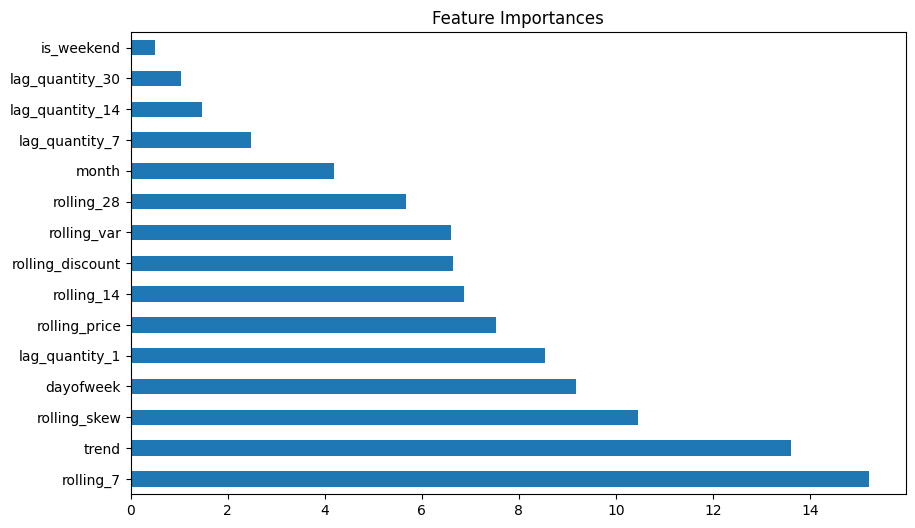

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# After model is trained
importances = catboost_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

feat_imp.plot(kind='barh', figsize=(10,6))
plt.title("Feature Importances")
plt.show()

In [68]:
# Aggregate predicted quantities by item and warehouse
inventory_df = prediction_df.groupby(['item_name', 'warehouse_id'])['predicted_quantity'].sum().reset_index()

# Optional: sort it for better readability
inventory_df = inventory_df.sort_values(['warehouse_id', 'item_name']).reset_index(drop=True)

print("\n📦 Inventory Planning Summary:")
print(inventory_df.head())



📦 Inventory Planning Summary:
                              item_name  warehouse_id  predicted_quantity
0                      Adani Mota Besan             1               26.26
1                             Ajinomoto             1                5.20
2                             Arhar Dal             1              196.00
3                               Arrarot             1                9.73
4  Ashok Kitchen King Masala Pkt(100gm)             1                9.13


In [69]:
inventory_df[inventory_df['predicted_quantity']==inventory_df['predicted_quantity'].max()]

,item_name,warehouse_id,predicted_quantity
153,Ruchi Gold Palm Pouch(1L),3,8540.38


In [60]:
prediction_df[(prediction_df['item_name']=='Ruchi Gold Palm Pouch(1L)')&(prediction_df['warehouse_id']==3)]['predicted_quantity'].sum()

np.float64(6613.369999999999)

In [70]:
prediction_df[prediction_df['customer_id']==1]

,customer_id,item_name,warehouse_id,predicted_quantity
166,1,Prakash Maida,2,1.57
342,1,Shreshtha Aata,2,12.52


In [72]:
data1[(data1['item_name']=='Prakash Maida')&(data1['customer_id']==1)].sort_values('order_date')

,order_id,item_name,quantity,invoiced_quantity,mrp,price_per_unit,amount,discount_amount,profit,order_date,customer_id,warehouse_name,warehouse_id
7499,70233,Prakash Maida,1,1,1750.0,1650.0,1750.0,100.0,10.0,2024-10-09,1,Telibagh,2
1086,70791,Prakash Maida,1,1,1750.0,1650.0,1750.0,100.0,10.0,2024-10-11,1,Telibagh,2
11134,72727,Prakash Maida,1,1,1745.0,1680.0,1745.0,65.0,25.0,2024-10-17,1,Telibagh,2
16380,76150,Prakash Maida,1,1,1745.0,1650.0,1745.0,95.0,0.0,2024-10-28,1,Telibagh,2
21428,78564,Prakash Maida,1,1,1778.0,1680.0,1778.0,98.0,0.0,2024-11-08,1,Telibagh,2
19501,79798,Prakash Maida,1,1,1788.0,1690.0,1788.0,98.0,0.0,2024-11-11,1,Telibagh,2
24828,81038,Prakash Maida,2,2,1788.0,1690.0,3576.0,196.0,0.0,2024-11-15,1,Telibagh,2
246,83246,Prakash Maida,1,1,1768.0,1670.0,1768.0,98.0,0.0,2024-11-22,1,Telibagh,2
35637,87323,Prakash Maida,1,1,1768.0,1670.0,1768.0,98.0,0.0,2024-12-04,1,Telibagh,2
35638,87328,Prakash Maida,1,1,1768.0,1690.0,1768.0,78.0,20.0,2024-12-04,1,Telibagh,2


In [77]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# Sample Data
# Assuming you have a dataframe 'data' with 'customer_id', 'item_name', 'warehouse_id', 'order_date', and 'quantity'

# Helper function: Validate groups with sufficient data
def is_valid_group(group):
    df = group[1].groupby('order_date')['quantity'].sum().reset_index()
    return len(df) >= 2 and df['quantity'].fillna(0).sum() > 0

# Forecasting function with Prophet
def forecast_with_prophet(group_data):
    (cid, item, wid), df = group_data

    df = df.groupby('order_date')['quantity'].sum().reset_index()
    df.columns = ['ds', 'y']

    # Skip groups that are too sparse or invalid
    if len(df) < 2 or df['y'].fillna(0).sum() == 0:
        return None

    try:
        # Train-test split (train 14 days, predict next 14)
        train = df[:-14]
        test = df[-14:]

        if len(train) < 2:
            return None

        model = Prophet(daily_seasonality=True)
        model.fit(train)

        future = model.make_future_dataframe(periods=14)
        forecast = model.predict(future)

        y_true = test['y'].values
        y_pred = forecast.iloc[-14:]['yhat'].values

        # Metrics
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        total_forecast = forecast.iloc[-14:]['yhat'].clip(lower=0).sum()

        return {
            'customer_id': cid,
            'item_name': item,
            'warehouse_id': wid,
            'predicted_quantity': round(total_forecast, 2),
            'train_mae': mean_absolute_error(train['y'], model.predict(train)['yhat']),
            'train_rmse': np.sqrt(mean_squared_error(train['y'], model.predict(train)['yhat'])),
            'train_r2': r2_score(train['y'], model.predict(train)['yhat']),
            'val_mae': mae,
            'val_rmse': rmse,
            'val_r2': r2
        }

    except Exception:
        return None

# Collect the groups (customer-item-warehouse) as list of tuples for multiprocessing
groups = [
    (key, group) for key, group in data.groupby(['customer_id', 'item_name', 'warehouse_id'])
    if is_valid_group((key, group))
]

# Multiprocessing with ProcessPoolExecutor
results = []
with ProcessPoolExecutor() as executor:
    for result in tqdm(executor.map(forecast_with_prophet, groups), total=len(groups), desc="📈 Forecasting", position=0, leave=True):
        if result is not None:
            results.append(result)

# Convert the results to a DataFrame
forecast_df = pd.DataFrame(results)

# Output the forecasted quantities for customer-item-warehouse pairs
print("\n📦 Forecast Results:")
print(forecast_df[['customer_id', 'item_name', 'warehouse_id', 'predicted_quantity']].head())

# Optionally: Aggregate for inventory planning across all warehouses
inventory_df = forecast_df.groupby(['item_name', 'warehouse_id'])['predicted_quantity'].sum().reset_index()

# Display the aggregated inventory forecast
print("\n📦 Aggregated Inventory Forecast:")
print(inventory_df.head())

# Calculate overall accuracy metrics
def print_overall_accuracy(forecast_df):
    # Aggregate all the metrics across the forecast_df
    overall_mae = np.mean(forecast_df['val_mae'])
    overall_rmse = np.mean(forecast_df['val_rmse'])
    overall_r2 = np.mean(forecast_df['val_r2'])

    print("\n📊 Overall Prophet Model Accuracy:")
    print(f"Overall MAE:  {overall_mae:.4f}")
    print(f"Overall RMSE: {overall_rmse:.4f}")
    print(f"Overall R²:   {overall_r2:.4f}")

# Print overall accuracy metrics for all forecasts
print_overall_accuracy(forecast_df)


📈 Forecasting: 100%|██████████| 12246/12246 [02:04<00:00, 98.10it/s] 



📦 Forecast Results:
   customer_id               item_name  warehouse_id  predicted_quantity
0            4           Prakash Maida             1               14.00
1           13            Prakash Aata             1               14.00
2           34             Kezar Maida             1                2.37
3           46  Hari Patti(Green) Rice             1              140.13
4           46       Pukhraj Arhar Dal             1               14.00

📦 Aggregated Inventory Forecast:
                      item_name  warehouse_id  predicted_quantity
0  Aashirwad Chakki Atta (10kg)             3              420.89
1   Aashirwad Chakki Atta (5kg)             3              388.99
2              Adani Mota Besan             1               28.00
3              Adani Mota Besan             2               27.91
4             Adani Patla Besan             2               44.87

📊 Overall Prophet Model Accuracy:
Overall MAE:  4.5445
Overall RMSE: 6.2780
Overall R²:   -130.4701


In [76]:
forecast_df[forecast_df['customer_id']==1]

,customer_id,item_name,warehouse_id,predicted_quantity,train_mae,train_rmse,train_r2,val_mae,val_rmse,val_r2
